In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.ticker import MaxNLocator

In [38]:
df = pd.read_csv("C:/Users/44773/Documents/Norwich xG.csv")

In [39]:
df['xGF'] = df['xGF'].str.split(',')
df['xGA'] = df['xGA'].str.split(',')
df['xGF'] = df['xGF'].apply(lambda lst: [float(x) for x in lst])
df['xGA'] = df['xGA'].apply(lambda lst: [float(x) for x in lst])

In [40]:
def simulate_match_xpts(xGF_shots, xGA_shots, n_simulations=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Store match outcomes
    results = {"win": 0, "draw": 0, "loss": 0}

    for _ in range(n_simulations):
        # Simulate goals from xG lists
        goals_for = sum(np.random.rand(len(xGF_shots)) < xGF_shots)
        goals_against = sum(np.random.rand(len(xGA_shots)) < xGA_shots)

        # Determine result
        if goals_for > goals_against:
            results["win"] += 1
        elif goals_for == goals_against:
            results["draw"] += 1
        else:
            results["loss"] += 1

    # Calculate expected points
    xPts = (
        results["win"] / n_simulations * 3
        + results["draw"] / n_simulations * 1
        + results["loss"] / n_simulations * 0
    )

    return round(xPts, 3), results

In [41]:
df[['xPts', 'sim_results']] = df.apply(
    lambda row: pd.Series(simulate_match_xpts(row['xGF'], row['xGA'])), axis=1
)


In [42]:
df['xPts_cumulative'] = df['xPts'].cumsum()
df['Pts_cumulative'] = df['Pts'].cumsum()

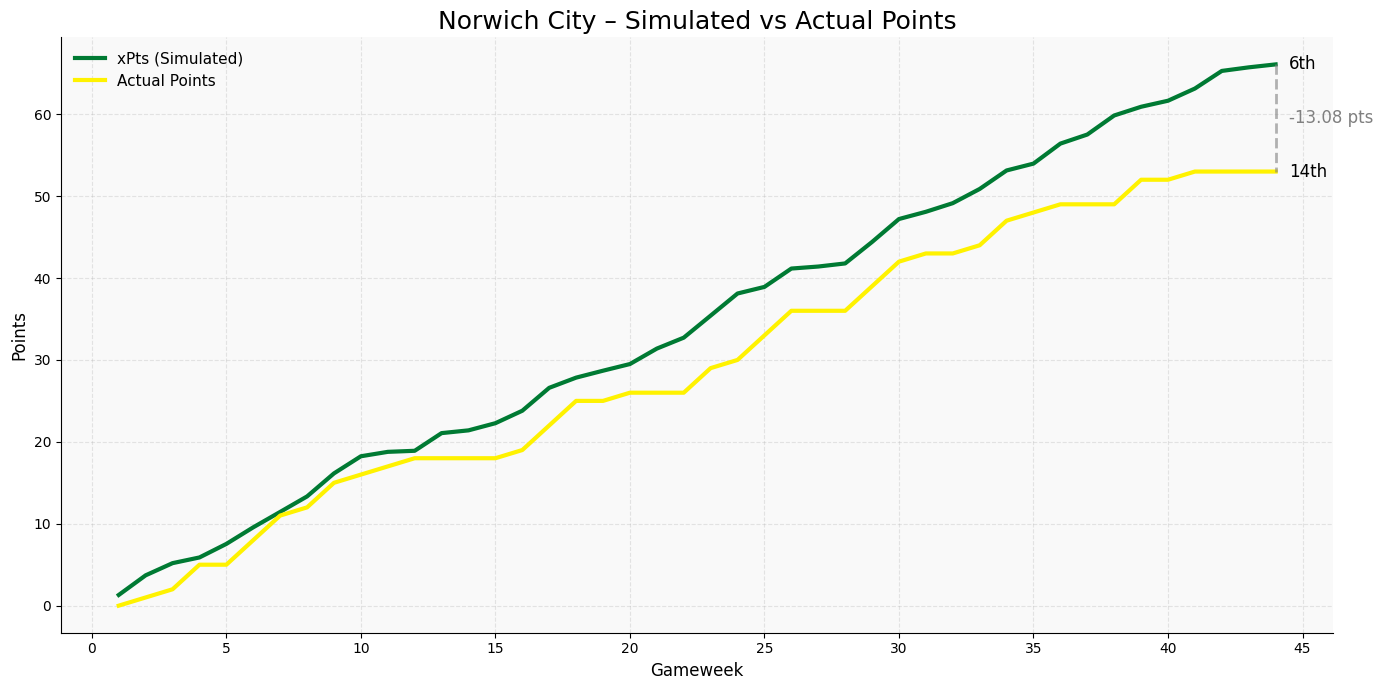

In [43]:
# === Load JPEG or PNG logo ===
logo_path = r"C:\Users\44773\Documents\Norwich_City_FC_logo.jpeg"
badge = Image.open(logo_path)  # Resize as needed

# Plot setup
fig, ax = plt.subplots(figsize=(14, 7))

# Line plots
ax.plot(df['GW'], df['xPts_cumulative'], color='#007a33', linewidth=3, label='xPts (Simulated)')
ax.plot(df['GW'], df['Pts_cumulative'], color='#fff200', linewidth=3, label='Actual Points')

# Aesthetics
ax.set_facecolor('#f9f9f9')
ax.grid(True, which='major', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Title + subtitle
plt.title("Norwich City – Simulated vs Actual Points", fontsize=18)
# plt.suptitle("Cumulative xPts vs Actual Points (Shot-by-Shot Simulation)", fontsize=12, y=0.92)

# Axis labels
ax.set_xlabel("Gameweek", fontsize=12)
ax.set_ylabel("Points", fontsize=12)

# Add final annotation
last_gw = df['GW'].iloc[-1]
final_xpts = df['xPts_cumulative'].iloc[-1]
final_pts = df['Pts_cumulative'].iloc[-1]
diff = final_pts - final_xpts

ax.plot(
    [last_gw, last_gw],
    [final_xpts, final_pts],
    color='grey',
    linewidth=2,
    linestyle='--',
    alpha=0.6
)

ax.text(
    last_gw + 0.5,
    (final_xpts + final_pts) / 2,
    f"{diff:+.2f} pts",
    fontsize=12,
    color='grey',
    va='center'
)

ax.text(
    last_gw + 0.5,
    final_xpts,
    "6th",
    fontsize=12,
    va='center'
)

# Label Pts rank
ax.text(
    last_gw + 0.5,
    final_pts,
    "14th",
    fontsize=12,
    va='center'
)

# Legend
plt.legend(frameon=False, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

In [44]:
final_xpts

np.float64(66.08200000000001)

In [45]:
df['GW'] = df['GW'].astype(int)

In [46]:
df['xGF_total'] = df['xGF'].apply(sum)
df['xGF_rolling'] = df['xGF_total'].rolling(window=5).mean()

In [47]:
df['xGA_total'] = df['xGA'].apply(sum)
df['xGA_rolling'] = df['xGA_total'].rolling(window=5).mean()

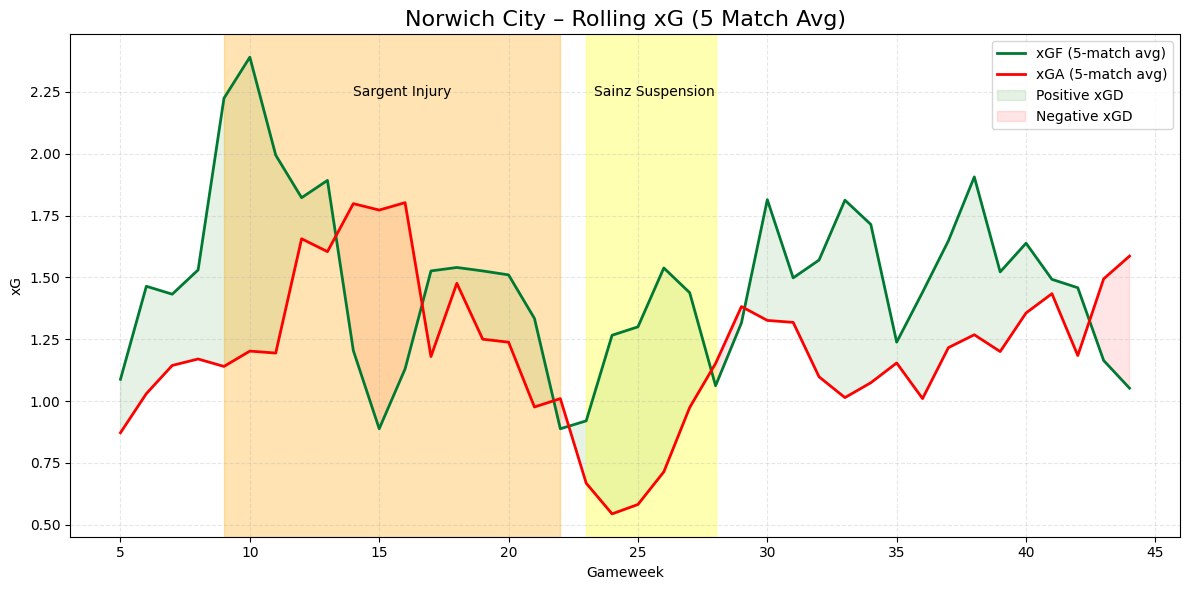

In [48]:
# Create mask to exclude rows with NaNs in rolling xG
mask = df['xGF_rolling'].notna() & df['xGA_rolling'].notna()
plt.figure(figsize=(12, 6))
plt.plot(df['GW'], df['xGF_rolling'], label='xGF (5-match avg)', color='#007a33', linewidth=2)
plt.plot(df['GW'], df['xGA_rolling'], label='xGA (5-match avg)', color='red', linewidth=2)

plt.fill_between(df['GW'][mask], df['xGF_rolling'][mask], df['xGA_rolling'][mask],
                 where=(df['xGF_rolling'][mask] > df['xGA_rolling'][mask]),
                 interpolate=True, color='green', alpha=0.1, label='Positive xGD')
plt.fill_between(df['GW'][mask], df['xGF_rolling'][mask], df['xGA_rolling'][mask],
                 where=(df['xGF_rolling'][mask] <= df['xGA_rolling'][mask]),
                 interpolate=True, color='red', alpha=0.1, label='Negative xGD')

plt.axvspan(23, 28, color='yellow', alpha=0.3)
plt.text(23.3, 2.25, 'Sainz Suspension', verticalalignment='center', fontsize=10)

plt.axvspan(9, 22, color='orange', alpha=0.3)
plt.text(14, 2.25, 'Sargent Injury', verticalalignment='center', fontsize=10)

# Styling
plt.title("Norwich City – Rolling xG (5 Match Avg)", fontsize=16)
plt.xlabel("Gameweek")
plt.ylabel("xG")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()